# RCによる外力ありのVDPの予測を行う。

まず、ライブラリをインポートする。

In [5]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge

from reservoirpy.observables import nrmse, rsquare

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

VDPモデルを数値シミュレーションする。

timestepは2510に設定する。

（内訳：
学習期間は1000ステップ。

テスト期間は1000ステップ。

その後500ステップ弱をGenerative Modelで予測する。
）


In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X 
    
    return [dXdt, dYdt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 2510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 2510))

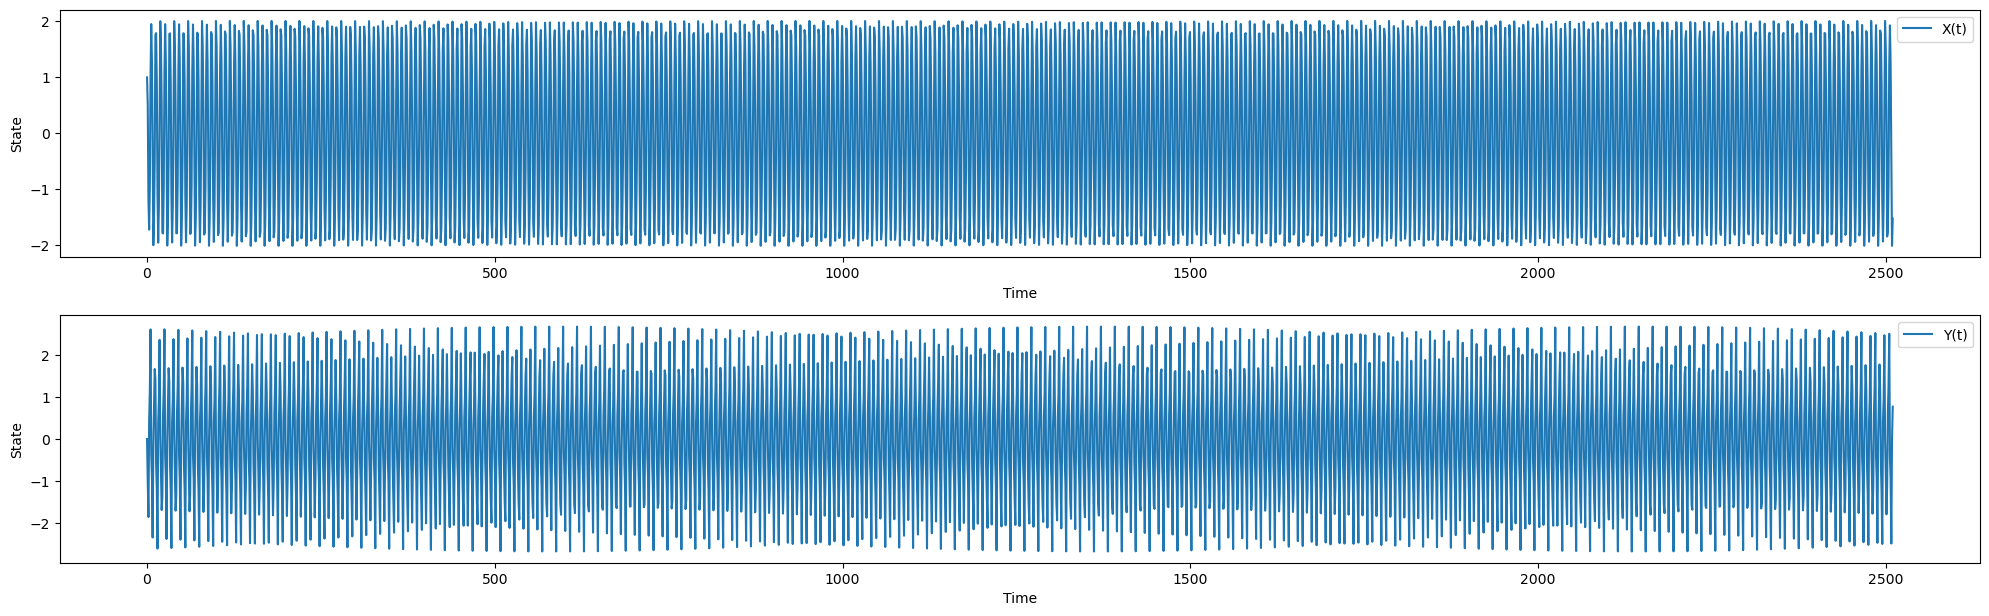

In [10]:
# Plot the results
plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
plt.plot(sol.t, sol.y[0], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t, sol.y[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [13]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [14]:
X = data.values

In [15]:
X.shape

(2510, 2)

これで、2510にわたる、ローレンツモデルのx項を外力に持つVDPの配列を得ることができた。

#### 学習させるのは、どのパラメータ？

描画は後にする。

In [16]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [17]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

データを準備する。

学習期間は1000ステップ。
テスト期間は1000ステップ。

In [96]:
from reservoirpy.datasets import to_forecasting

train_len = 1000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:1000], y[:1000]
X_test, y_test = x[1000:2000], y[1000:2000]
X_gen_test, y_gen_test = x[2000:], y[2000:]

dataset = ((X_train, y_train), (X_test, y_test))

In [80]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [02:41<00:00,  1.23trial/s, best loss: 1.4730906888357204e-05]


学習対象を2つから5つに増やすと、予測精度が上がった。

In [81]:
best

({'N': 0,
  'iss': 0.9408397105778058,
  'lr': 0.3594469868947466,
  'ridge': 2.899155403260927e-08,
  'seed': 0,
  'sr': 0.953319122623503},
 <hyperopt.base.Trials at 0x16b926970>)

In [82]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.9408397105778058
lr = 0.3594469868947466
ridge = 2.899155403260927e-08
seed = 1234
sr = 0.953319122623503

In [83]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [84]:
# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 1.6971693446740775e-05
R^2: 0.9999999959851866


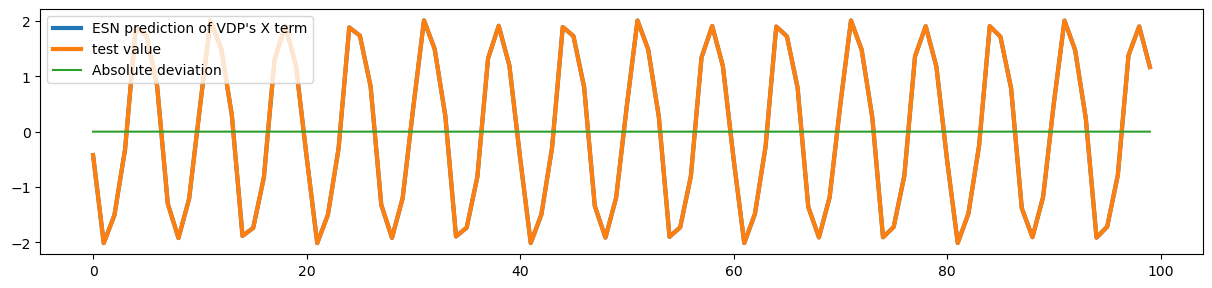

In [85]:
sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

In [86]:
nrmse(y_test[:, :1], predictions[:, :1])

5.651950538949327e-06

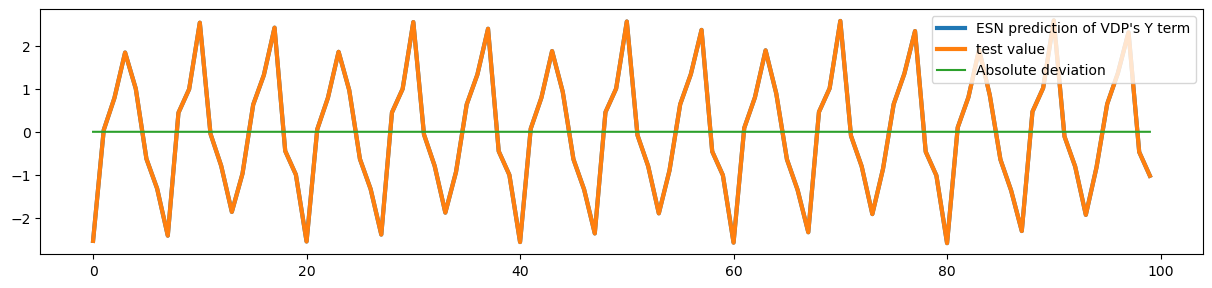

In [87]:
sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

ここまで、通常の1期先予測の方法を見た。

さて、ここから、ESNに自分の予測に基づいて、100期先までを予測してもらう。

# Generative Modelを使う。

100期以前の情報を用いて、400期先までの予測を行う（実際気にするのはより小さい数）。

In [119]:
seed_timesteps = 1000

warming_inputs = X_test

warming_out = model.run(warming_inputs, reset=True)  # warmup

In [145]:
warming_out[-10:][:, :1]

array([[ 1.48480459],
       [ 1.87722748],
       [ 1.11874831],
       [-0.65641931],
       [-2.00261765],
       [-1.4346039 ],
       [-0.14334251],
       [ 1.9464183 ],
       [ 1.67912191],
       [ 0.70359236]])

In [146]:
y_test[-10:][:, :1]

array([[ 1.48481598],
       [ 1.87719626],
       [ 1.11873862],
       [-0.6564474 ],
       [-2.00263405],
       [-1.43458041],
       [-0.14338532],
       [ 1.94644786],
       [ 1.6791252 ],
       [ 0.70358678]])

In [147]:
nrmse(warming_out[:, :1], y_test[:, :1])

0.009352920265156417

In [123]:
nb_generations = 509

X_gen = np.zeros((nb_generations, 2))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = model(y)
    X_gen[t, :] = y

In [129]:
X_gen[:10]

array([[-1.50390822, -2.09930638],
       [-1.87874745,  0.50196348],
       [-1.11904621,  1.06145515],
       [ 0.65414677,  2.65171408],
       [ 1.99776198, -0.19288582],
       [ 1.42686903, -0.83571381],
       [ 0.12502955, -2.0449256 ],
       [-1.95372023, -0.6104288 ],
       [-1.68035192,  0.67108351],
       [-0.7047665 ,  1.43660724]])

In [130]:
y_gen_test[:10]

array([[-1.50386503, -2.09927703],
       [-1.87875229,  0.50216266],
       [-1.11897947,  1.061683  ],
       [ 0.65445353,  2.65196845],
       [ 1.99773022, -0.19327872],
       [ 1.42675799, -0.83635458],
       [ 0.12426232, -2.04627358],
       [-1.9539033 , -0.609115  ],
       [-1.68006704,  0.67120754],
       [-0.70417835,  1.4372367 ]])

In [126]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=100):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

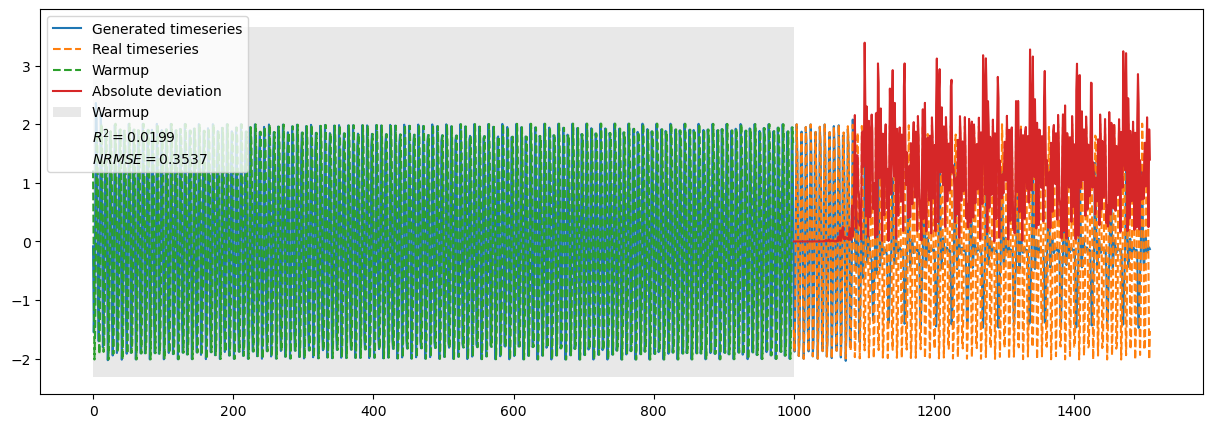

In [127]:
#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, :1], y_gen_test[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=1000)

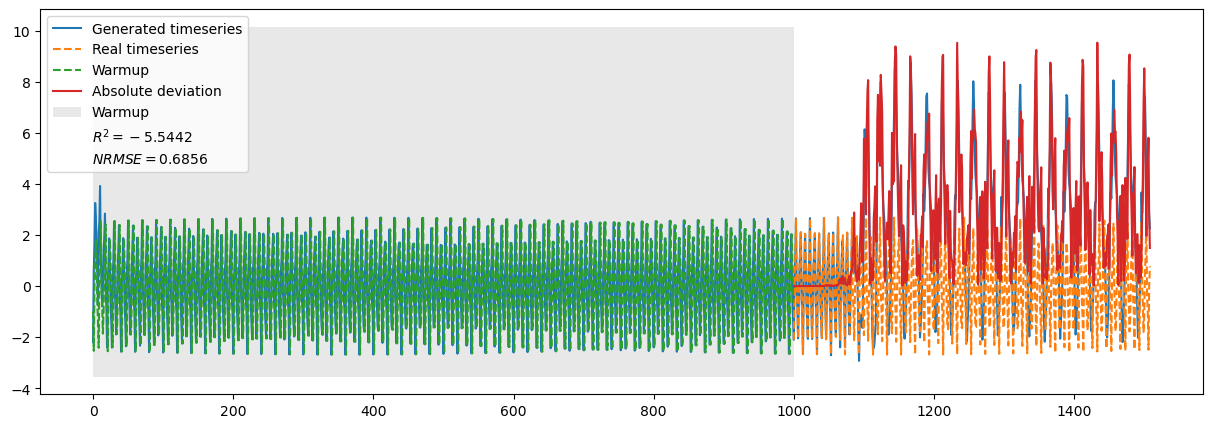

In [128]:
#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, 1:2], y_gen_test[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)